In [1]:
import pandas as pd
import glob 
import numpy as np
import os
import trajectory_planning_helpers as tph
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from f1tenth_sim.utils.MapData import MapData
from f1tenth_sim.utils.track_utils import RaceTrack, CentreLine


from f1tenth_sim.data_tools.general_plotting.plot_trajectory_analysis import plot_trajectory_analysis
from f1tenth_sim.data_tools.general_plotting.plot_raceline_tracking import plot_raceline_tracking

from f1tenth_sim.data_tools.plotting_utils import *
from f1tenth_sim.run_scripts.run_functions import *
import numpy as np


if os.getcwd().split('/')[-1] == 'Notebooks':
    os.chdir('..')
    print(f'Changed directory to root of repo: {os.getcwd()}')

save_path = 'Data/BenchmarkArticle/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

Changed directory to root of repo: /home/benjy/Documents/RacingRepos/f1tenth_sim


## Training Graphs

In [2]:

seeds = [12, 13, 14]
rewards = ["Progress", "CTH", "TAL"]
train_maps = ["mco", "gbr", "esp", "aut"]

total_training_steps = 50000
resampled_xs = np.linspace(0, total_training_steps, 50000)

avg_training_data = {}
min_training_data = {}
max_training_data = {}
avg_reward_data = {}
min_reward_data = {}
max_reward_data = {}
downsampled_xs = np.linspace(0, total_training_steps, 1000)

training_data = {}
for train_map in train_maps:
    for reward in rewards:
        temp_progress_data = []
        temp_reward_data = []
        for seed in seeds:
            test_id = f"TD3_{reward}_{seed}_{train_map}"

            root_path = f"Logs/EndToEnd/RawData_{test_id}/"
            results = pd.read_csv(root_path + f"TrainingData_{test_id}.csv")
            steps = results["Steps"]
            progresses = results["Progress"]*100

            resampled_progress = np.interp(resampled_xs, steps, progresses)
            temp_progress_data.append(resampled_progress)

            reward_hsitory = np.load(root_path + "RewardHistory.npy")
            resampled_rewards = np.interp(resampled_xs, steps, reward_hsitory)
            temp_reward_data.append(resampled_rewards)

        avg_training_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.mean(temp_progress_data, axis=0))
        min_training_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.min(temp_progress_data, axis=0))
        max_training_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.max(temp_progress_data, axis=0))

        avg_reward_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.mean(temp_reward_data, axis=0))
        min_reward_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.min(temp_reward_data, axis=0))
        max_reward_data[f"{reward}_{train_map}"] = np.interp(downsampled_xs, resampled_xs, np.max(temp_reward_data, axis=0))

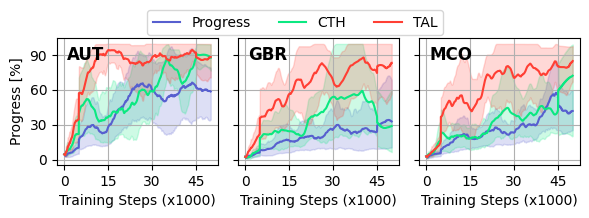

In [3]:

colors = [periwinkle, minty_green, red_orange]
period = 100

plot_maps = ["aut", "gbr", "mco"]
fig, ax = plt.subplots(1, len(plot_maps), figsize=(6, 2), sharex=True, sharey=True)
for i, train_map in enumerate(plot_maps):
    axs = ax[i]
    for j, reward in enumerate(rewards):
        ys = avg_training_data[f"{reward}_{train_map}"]
        ys = true_moving_average(ys, period)
        ax[i].plot(downsampled_xs/1e3, ys, label=reward, color=colors[j])
        ys_min = true_moving_average(min_training_data[f"{reward}_{train_map}"], period)
        ys_max = true_moving_average(max_training_data[f"{reward}_{train_map}"], period)
        axs.fill_between(downsampled_xs/1e3, ys_min, ys_max, alpha=0.2, color=colors[j])

    axs.text(1, 86, f"{train_map.upper()}", fontdict={"fontsize": 12, "fontweight": "bold"})
    axs.set_xlabel("Training Steps (x1000)")
    axs.grid()
ax[0].set_ylabel("Progress [%]")
ax[0].yaxis.set_major_locator(plt.MaxNLocator(4))
ax[0].xaxis.set_major_locator(plt.MaxNLocator(4))

h, l = ax[0].get_legend_handles_labels()
# fig.legend(h[::2], ["Progress", "CTH", "TAL"], loc="upper center", ncol=3)
# fig.legend(["Progress", "CTH", "TAL"], loc="upper center", ncol=3)
fig.legend(h, ["Progress", "CTH", "TAL"], loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.1))

plt.tight_layout()
plt.savefig(f"{save_path}BenchmarkProgressTraining.pdf", bbox_inches='tight')
plt.savefig(f"{save_path}BenchmarkProgressTraining.svg", bbox_inches='tight')

In [4]:
summary_df = pd.read_csv("Logs/Summary.csv")

map_list = ["aut", "esp", "gbr", "mco"]

avg_data = {}
min_data = {}
max_data = {}
for i, reward in enumerate(rewards):
    for train_map in map_list:
        test_ids = [f"TD3_{reward}_{seed}_{train_map}" for seed in seeds]
        mini_df = summary_df.loc[summary_df.TestID.isin(test_ids)].drop(columns=["TestID", "Vehicle", "VehicleID"])
        avg_data[f"{reward}_{train_map}"] = mini_df.groupby("MapName").mean()

avg_data = pd.concat(avg_data).reset_index().fillna(0)
avg_data["Reward"] = avg_data["level_0"].apply(lambda x: x.split("_")[0])
avg_data["TrainMap"] = avg_data["level_0"].apply(lambda x: x.split("_")[1])
avg_data = avg_data.drop(columns=["level_0", "StdTime"])
avg_data = avg_data.rename(columns={"MapName": "TestMap"})

# print(avg_data)
avg_data.to_csv("Logs/drl_avg_data.csv", index=False)



Reward TrainMap        CTH   Progress        TAL
0           aut  55.310000  27.836667  72.813333
1           esp  32.020000  15.816667  48.420000
2           gbr  16.746667  18.763333  72.873333
3           mco  47.533333  36.006667  80.303333
Reward TrainMap      CTH  Progress        TAL
0           aut   63.915     32.68  43.896000
1           esp   75.440      0.00  36.424000
2           gbr    0.000     29.68  36.756000
3           mco  120.832     31.90  38.356667


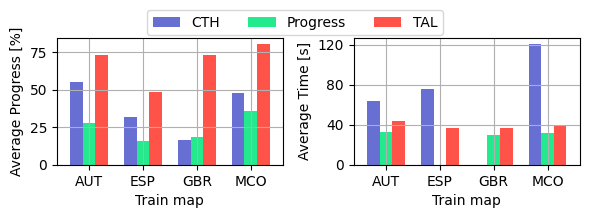

In [5]:

summary_df = pd.read_csv("Logs/drl_avg_data.csv")

fig, ax = plt.subplots(1, 2, figsize=(6, 2.), sharex=True)

xs = np.arange(len(map_list))
width = 0.7
test_map = 'mco'

axs = ax[0]
grouped_df = avg_data.loc[avg_data.TestMap == test_map]
grouped_df = grouped_df[["AvgProgress", "TrainMap", "Reward"]]
grouped_df["AvgProgress"] = grouped_df["AvgProgress"]*100
grouped_df = pd.pivot_table(grouped_df, index="TrainMap", columns="Reward", values="AvgProgress")
grouped_df = grouped_df.reset_index("TrainMap")
print(grouped_df)
grouped_df.plot.bar(ax=axs, color=colors, width=width, position=1, legend=False, alpha=0.9)

axs.set_xticks(xs - width/2)
axs.set_xticklabels([x.upper() for x in map_list], rotation=0)
axs.set_xlabel(f"Train map")
axs.grid()
axs.set_ylabel("Average Progress [%]")

axs = ax[1]
grouped_df = avg_data.loc[avg_data.TestMap == test_map] 
grouped_df = grouped_df[["AvgTime", "TrainMap", "Reward"]]
grouped_df = pd.pivot_table(grouped_df, index="TrainMap", columns="Reward", values="AvgTime")
grouped_df = grouped_df.reset_index("TrainMap")
print(grouped_df)
grouped_df.plot.bar(ax=axs, color=colors, width=width, position=1, legend=False, alpha=0.9)


axs.set_xticks(xs - width/2)
axs.yaxis.set_major_locator(plt.MaxNLocator(4))
axs.set_xticklabels([x.upper() for x in map_list], rotation=0)
axs.set_xlabel(f"Train map")
axs.grid()
axs.set_ylabel("Average Time [s]")
fig.legend(["CTH", "Progress", "TAL"], loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.1))

plt.tight_layout()

plt.savefig(f"{save_path}BenchmarkArticle_TestResults_{test_map}.pdf", bbox_inches="tight")
plt.savefig(f"{save_path}BenchmarkArticle_TestResults_{test_map}.svg", bbox_inches="tight")

/tmp/ipykernel_1779723/2925183497.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


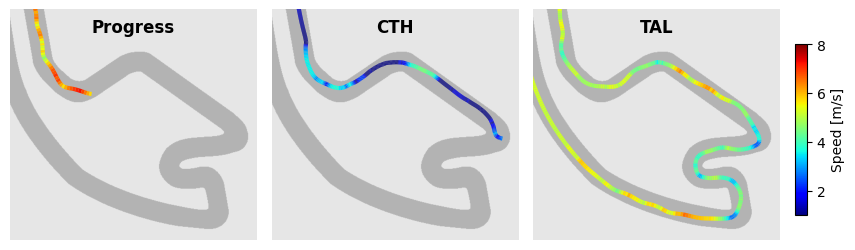

In [52]:
planner_name = "EndToEnd"
seed = 14
train_map = "esp"
test_map = "mco"
test_ids = [f"TD3_{reward}_{seed}_{train_map}" for reward in rewards]
frequency = 25
lap_n = 3

map_data = MapData(test_map)
fig, axs = plt.subplots(1, len(test_ids), figsize=(8, 10), sharex=True, sharey=True)

for i, test_id in enumerate(test_ids):
        data = np.load(f"Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{test_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
        df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])

        plt.sca(axs[i])
        map_data.plot_map_img()

        xs, ys = map_data.xy2rc(df.x, df.y)
        pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
        segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
        norm = plt.Normalize(1, 8)
        lc = LineCollection(segments, cmap='jet', norm=norm)
        lc.set_array(df.speed.values)
        lc.set_linewidth(3)
        line = plt.gca().add_collection(lc)


        plt.axis('off')
        axs[i].set_aspect('equal')
        plt.xlim(650, 1110)
        plt.ylim(70, 500)
        plt.text(0.5, 0.92, f"{rewards[i]}", horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes, fontsize=12, fontweight="bold")

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.1, ax.get_position().y0, 0.015, ax.get_position().height])
plt.colorbar(line, cax=cax, label="Speed [m/s]", ticks=[2, 4, 6, 8])
plt.tight_layout()

plt.savefig(f"{save_path}drl_trajectories_{test_map}.svg", bbox_inches='tight')
plt.savefig(f"{save_path}drl_trajectories_{test_map}.pdf", bbox_inches='tight')


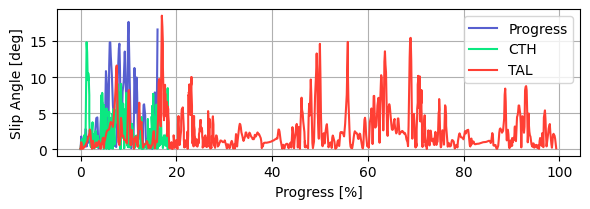

In [54]:
planner_name = "EndToEnd"
seed = 14
train_map = "mco"
test_map = "mco"
test_ids = [f"TD3_{reward}_{seed}_{train_map}" for reward in rewards]
frequency = 25
lap_n = 3

map_data = MapData(test_map)
fig, axs = plt.subplots(1, 1, figsize=(6, 2.2), sharex=True, sharey=True)

for i, test_id in enumerate(test_ids):
        data = np.load(f"Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{test_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
        df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
        df.slip = df.slip.abs() * 180 / np.pi

        plt.plot(df.progress*100, df.slip, label=rewards[i], color=colors[i])

plt.legend()
plt.grid(True)
plt.xlabel("Progress [%]")
plt.ylabel("Slip Angle [deg]")

plt.tight_layout()

plt.savefig(f"{save_path}drl_slip_progress_{test_map}.svg", bbox_inches='tight')
plt.savefig(f"{save_path}drl_slip_progress_{test_map}.pdf", bbox_inches='tight')
